In [1]:
import velvetvae as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal
import pickle

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
def realign(trajectories, eps=0.005):
    fixed = []
    for i in range(trajectories.shape[0]):
        x = trajectories[i]
        # broadcast function to stop a trajectory at the point where it stops moving
        xx = x[np.cumsum(np.abs(np.diff(x, append=x[-1]))>eps)<np.cumsum(np.abs(np.diff(x))>eps).max()]
        if len(xx)==0:
            xx = np.array([0])
        fixed.append(xx)
    return fixed
    
def get_gene(gex, gene):
    gene = gex[:,:,np.where(adata.var_names==gene)[0][0]].detach().cpu().numpy()
    return gene

argmax = lambda x: [xi.argmax() for xi in x]

In [3]:
adata = sc.read_h5ad('../data/neural_data_0606.h5ad')

state_path = '../models/neural_vf_0606_model.pt'

vt.md.Velvet.setup_anndata(adata, x_layer='total', n_layer='new', knn_layer='knn_index')

model = vt.md.Velvet(
    adata,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

trained_state = torch.load(state_path)['model_state_dict']

model.module.load_state_dict(trained_state)

model.module = model.module.to('cuda')

INFO     Generating sequential column names                                                  


In [4]:
with open('../data/F4_noisy0.0_trajectories.pickle', 'rb') as f:
    data = pickle.load(f)
trajectories = data['MN']

In [5]:
gex = model.get_trajectory_gene_expression(trajectories)

In [69]:
# scores = []
# for m in tqdm(model.adata.var_names):
#     o = ['Olig2', m]
#     first = gex[:,:,np.where(adata.var_names==o[0])[0][0]].detach().cpu().numpy()
#     second = gex[:,:,np.where(adata.var_names==o[1])[0][0]].detach().cpu().numpy()
#     idx = (first.argmax(1)!=0)&(first.argmax(1)!=99)&(second.argmax(1)!=0)&(second.argmax(1)!=99)
    
#     sd_coef = np.corrcoef(first.argmax(1)[idx], second.argmax(1)[idx])[0,1]
#     scores.append(sd_coef)

In [70]:
# sns.kdeplot(np.sort(scores), cut=0)

In [71]:
# use = model.adata.var_names[np.argsort(scores)]
# for m in use[:200]:
#     o = ['Olig2', m]
#     first = gex[:,:,np.where(adata.var_names==o[0])[0][0]].detach().cpu().numpy()
#     second = gex[:,:,np.where(adata.var_names==o[1])[0][0]].detach().cpu().numpy()
#     idx = (first.argmax(1)!=0)&(first.argmax(1)!=99)&(second.argmax(1)!=0)&(second.argmax(1)!=99)

#     if second.max()>1:    
#         fig = plt.figure(figsize=(4,2), dpi=150)
#         ax1, ax2 = fig.subplots(1,2)
#         ax1.scatter(first.argmax(1)[idx], second.argmax(1)[idx])
#         for s in second:
#             ax2.plot(s, alpha=0.5)
#         plt.suptitle(', '.join(o))
#         ax1.set_xlim(0,50)
#         ax1.set_ylim(0,100)
#         plt.show()

# known genes

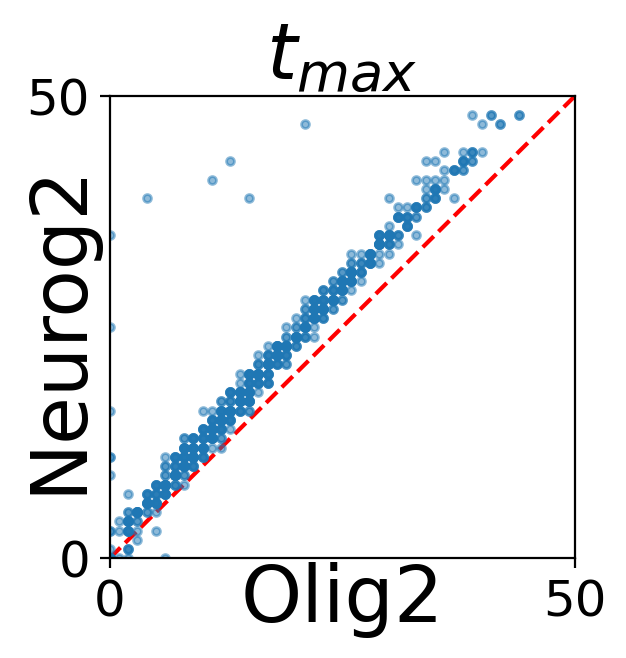

In [9]:
o = ['Olig2','Neurog2']

fontsize=28

first = realign(get_gene(gex, o[0]))
second = realign(get_gene(gex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, zorder=2)
plt.xlim(0,50)
plt.ylim(0,50)
plt.plot([0,50],[0,50], color='r', linestyle='--', zorder=1)
plt.xticks([0,plt.gca().get_xticks().max()], fontsize=18)
plt.yticks([0,plt.gca().get_yticks().max()], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"$t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_nSDE1.png', bbox_inches='tight')
plt.show()


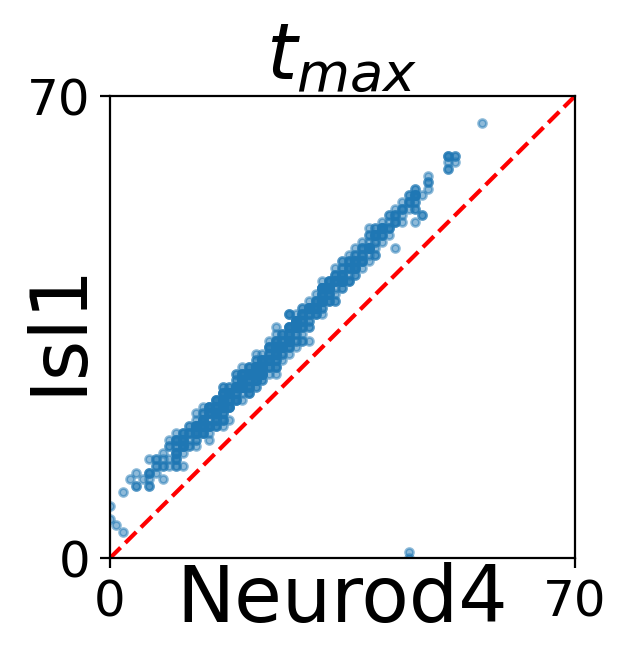

In [10]:
o = ['Neurod4','Isl1']

fontsize=28

first = realign(get_gene(gex, o[0]))
second = realign(get_gene(gex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5)
plt.plot([0,70],[0,70], color='r', linestyle='--')
plt.xlim((0,70))
plt.ylim((0,70))
plt.xticks([0,70], fontsize=18)
plt.yticks([0,70], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"$t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_nSDE2.png', bbox_inches='tight')
plt.show()


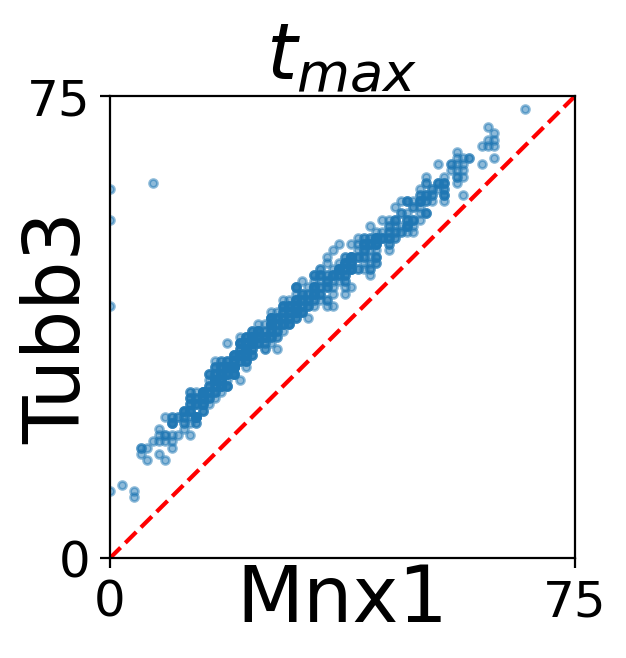

In [11]:
o = ['Mnx1','Tubb3']

fontsize=28

first = realign(get_gene(gex, o[0]))
second = realign(get_gene(gex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5)
plt.plot([0,75],[0,75], color='r', linestyle='--')
plt.xlim((0,75))
plt.ylim((0,75))
plt.xticks([0,75], fontsize=18)
plt.yticks([0,75], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"$t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_nSDE3.png', bbox_inches='tight')

plt.show()


# random genes

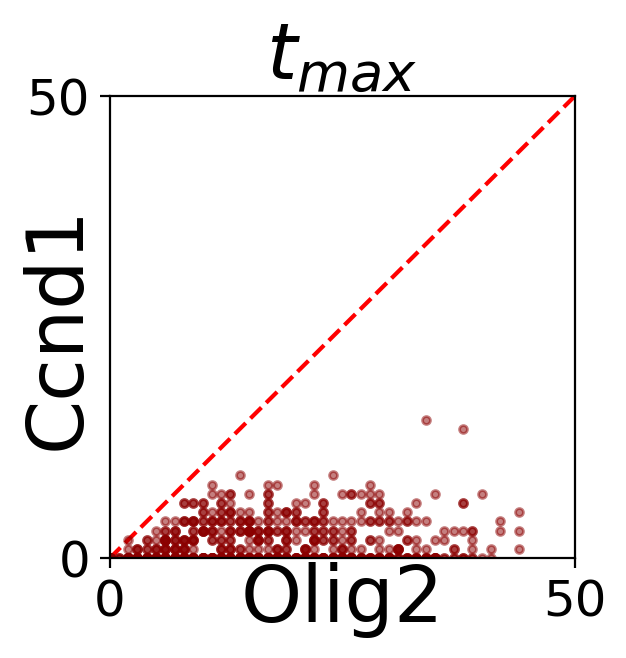

In [12]:
o = ['Olig2','Ccnd1']

fontsize=28

first = realign(get_gene(gex, o[0]))
second = realign(get_gene(gex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, color='darkred', zorder=2)
plt.xlim(0,50)
plt.ylim(0,50)
plt.plot([0,50],[0,50], color='r', linestyle='--', zorder=1)
plt.xticks([0,plt.gca().get_xticks().max()], fontsize=18)
plt.yticks([0,plt.gca().get_yticks().max()], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"$t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_nSDEBG1.png', bbox_inches='tight')

plt.show()


Cdca2 is cell cycle

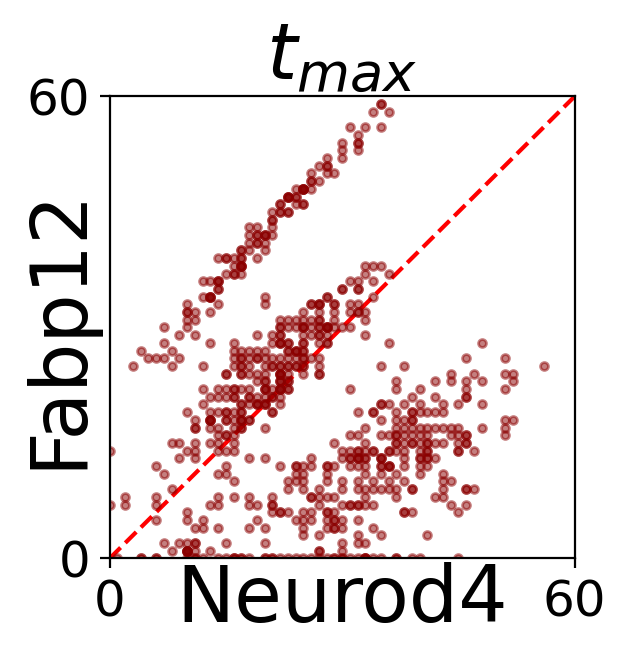

In [13]:
o = ['Neurod4','Fabp12']

fontsize=28

first = realign(get_gene(gex, o[0]))
second = realign(get_gene(gex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, color='darkred', zorder=2)
plt.xlim(0,60)
plt.ylim(0,60)
plt.plot([0,60],[0,60], color='r', linestyle='--', zorder=1)
plt.xticks([0,plt.gca().get_xticks().max()], fontsize=18)
plt.yticks([0,plt.gca().get_yticks().max()], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"$t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_nSDEBG2.png', bbox_inches='tight')

plt.show()


Fabp12 is (lipid) metabolism

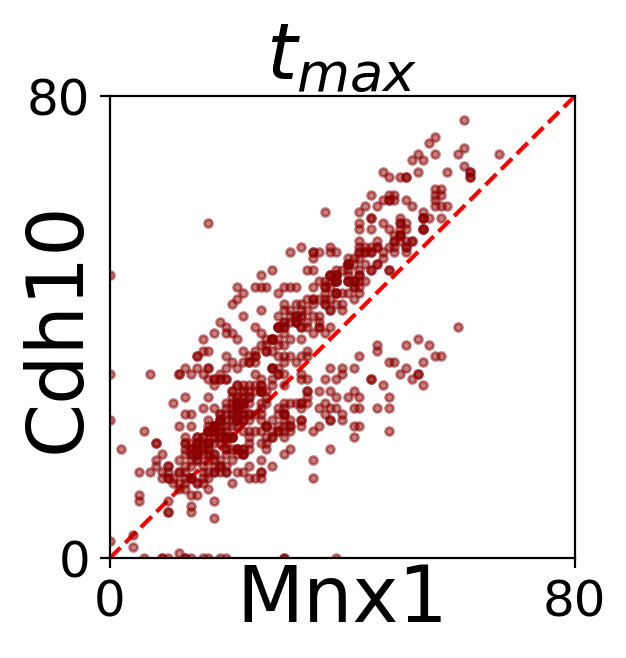

In [14]:
o = ['Mnx1','Cdh10']

fontsize=28

first = realign(get_gene(gex, o[0]))
second = realign(get_gene(gex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, color='darkred', zorder=2)
plt.xlim(0,80)
plt.ylim(0,80)
plt.plot([0,80],[0,80], color='r', linestyle='--', zorder=1)
plt.xticks([0,plt.gca().get_xticks().max()], fontsize=18)
plt.yticks([0,plt.gca().get_yticks().max()], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"$t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_nSDEBG3.png', bbox_inches='tight')

plt.show()


Cdh10 is a cadherin involved in membrane adhesion

# Null model

In [72]:
def random_walk(n, sigma=.1, steps=100, device='cuda'):
    pos = torch.zeros(n, device=device)
    rw = [pos.clone()]
    for i in range(steps-1):
        step = torch.randn(n, device=device)*sigma
        pos = pos + step
        rw.append(pos.clone())
    rw = torch.stack(rw)
    return rw

with open('../data/F4_noisy0.0_trajectories.pickle', 'rb') as f:
    data = pickle.load(f)
    
ave = data['MN']
average_trajectory = ave.median(0).values
inits = ave[:,0,:]

null = (inits.unsqueeze(1) + (average_trajectory - average_trajectory[0]).unsqueeze(0))
for i in range(null.shape[0]):
    null[i] = null[i] + random_walk(50, steps=100, sigma=0.1)
    
nullgex = model.get_trajectory_gene_expression(null)

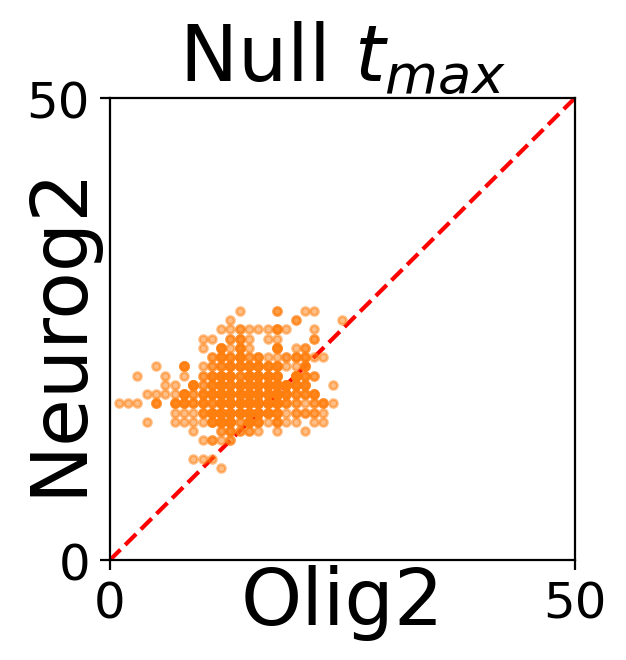

In [73]:
o = ['Olig2','Neurog2']

fontsize=28

first = realign(get_gene(nullgex, o[0]))
second = realign(get_gene(nullgex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, color='tab:orange', zorder=2)
plt.xlim(0,50)
plt.ylim(0,50)
plt.plot([0,50],[0,50], color='r', linestyle='--', zorder=1)
plt.xticks([0,plt.gca().get_xticks().max()], fontsize=18)
plt.yticks([0,plt.gca().get_yticks().max()], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"Null $t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_null1.png', bbox_inches='tight')

plt.show()


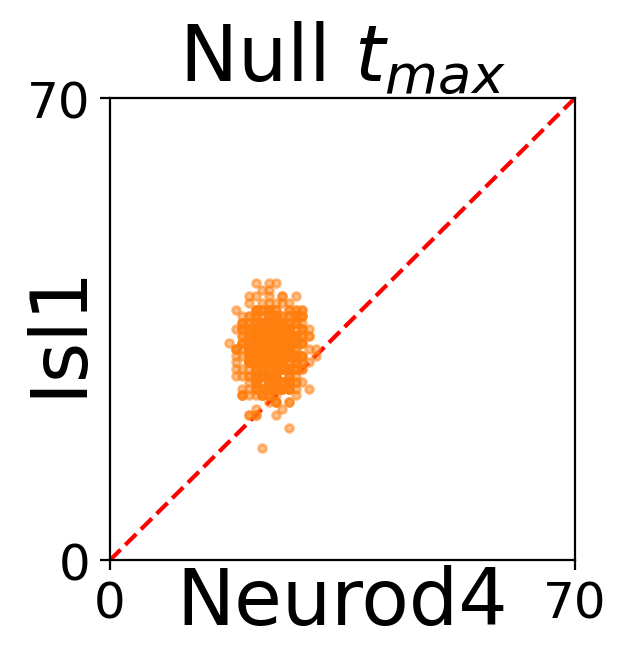

In [74]:
o = ['Neurod4','Isl1']

fontsize=28

first = realign(get_gene(nullgex, o[0]))
second = realign(get_gene(nullgex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, zorder=2, color='tab:orange')
plt.plot([0,70],[0,70], color='r', linestyle='--', zorder=1)
plt.xlim((0,70))
plt.ylim((0,70))
plt.xticks([0,70], fontsize=18)
plt.yticks([0,70], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"Null $t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_null2.png', bbox_inches='tight')

plt.show()


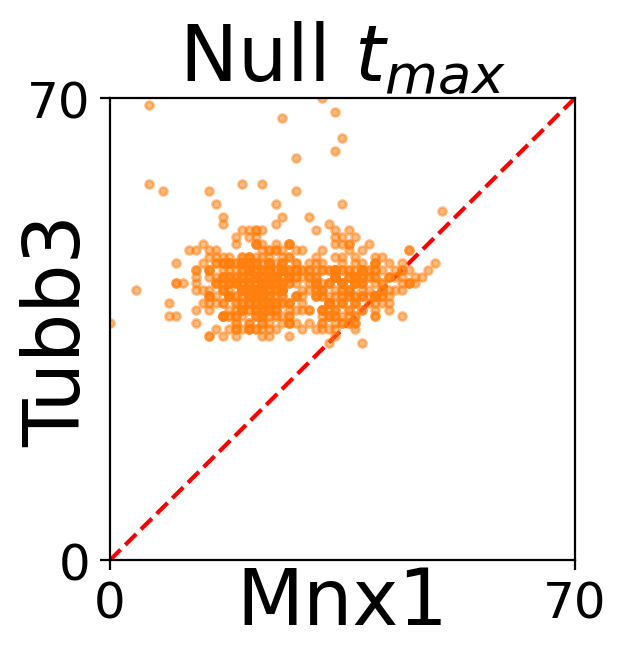

In [75]:
o = ['Mnx1','Tubb3']

fontsize=28

first = realign(get_gene(nullgex, o[0]))
second = realign(get_gene(nullgex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, zorder=2, color='tab:orange')
plt.plot([0,70],[0,70], color='r', linestyle='--', zorder=1)
plt.xlim((0,70))
plt.ylim((0,70))
plt.xticks([0,70], fontsize=18)
plt.yticks([0,70], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"Null $t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_null2.png', bbox_inches='tight')

plt.show()


# Null model 2

In [150]:
null2_trajectories = []
number = 200
for i in range(number):
    start = np.random.choice(1)
    null2 = average_trajectory[start:,:]
    null2 = null2 + random_walk(50, steps=100-start, sigma=0.000005)
    null2_trajectories.append(null2)

In [151]:
null2_gex = [model.get_trajectory_gene_expression(n2.unsqueeze(0)) for n2 in null2_trajectories]

In [154]:
a = 'Olig2'
b = 'Cdh10'

first = [get_gene(ng,a).flatten() for ng in null2_gex]
second = [get_gene(ng,b).flatten() for ng in null2_gex]

first = np.vstack([np.pad(t, (0, max(len(t) for t in first) - len(t))) for t in first])
second = np.vstack([np.pad(t, (0, max(len(t) for t in second) - len(t))) for t in second])

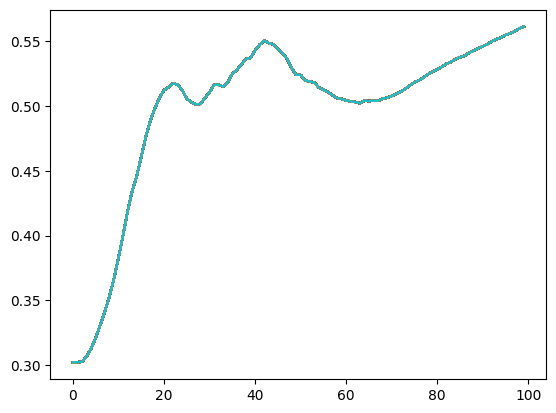

In [155]:
for s in second:
    plt.plot(s)

(0.0, 100.0)

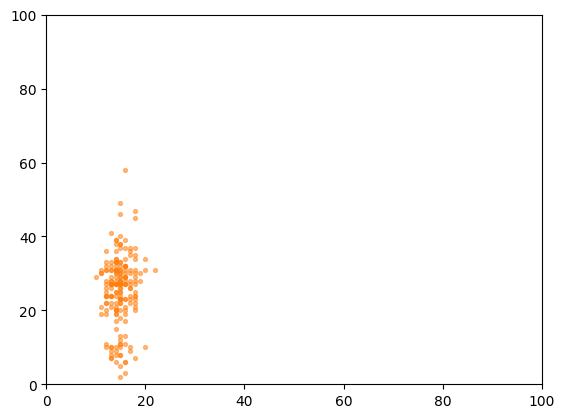

In [149]:
plt.scatter(first.argmax(1), second.argmax(1), s=8, alpha=0.5, zorder=2, color='tab:orange')
plt.xlim(0,100)
plt.ylim(0,100)

# Markov

In [18]:
with open(f'../data/F4_markov_trajectories.pickle', 'rb') as f:
    mark = pickle.load(f)
with open(f'../data/F4_pt10_bins.pickle', 'rb') as f:
    pt10 = pickle.load(f)

In [19]:
trajectories = mark['MN']
gex = model.get_trajectory_gene_expression(trajectories)

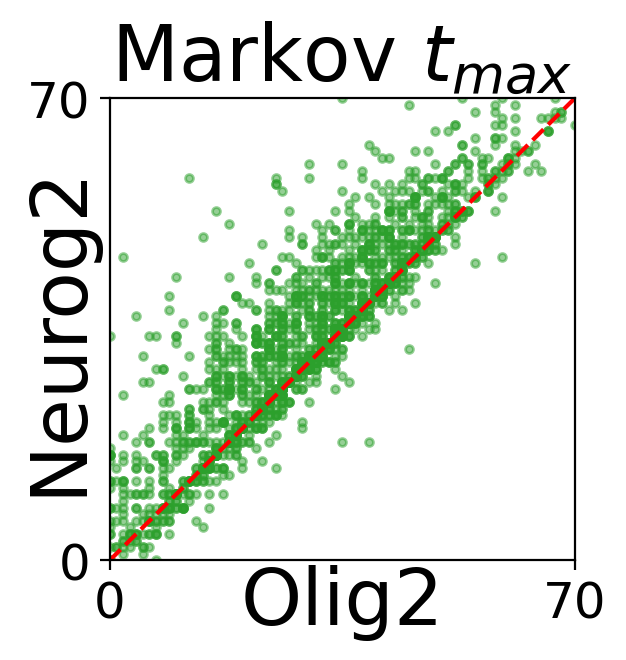

In [20]:
o = ['Olig2','Neurog2']

fontsize=28

first = realign(get_gene(gex, o[0]))
second = realign(get_gene(gex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, zorder=1, color='tab:green')
plt.xlim(0,70)
plt.ylim(0,70)
plt.plot([0,70],[0,70], color='r', linestyle='--', zorder=2)
plt.xticks([0,70], fontsize=18)
plt.yticks([0,70], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"Markov $t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_mark1.png', bbox_inches='tight')
plt.show()


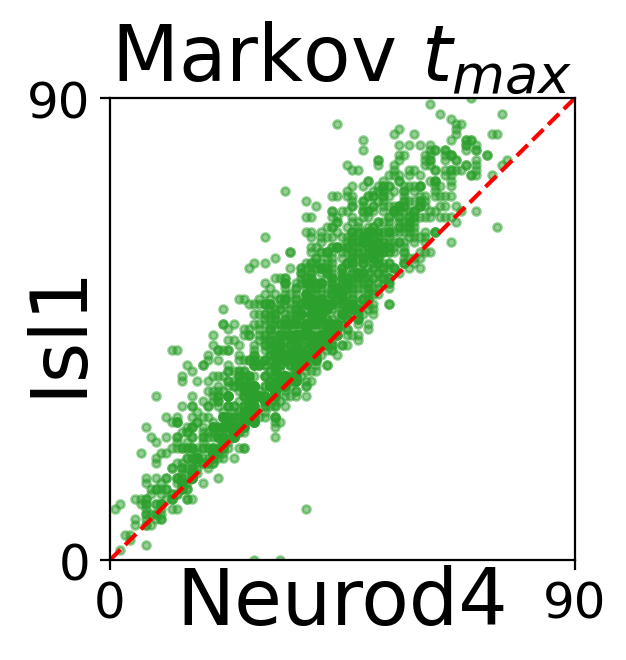

In [21]:
o = ['Neurod4','Isl1']

fontsize=28

first = realign(get_gene(gex, o[0]))
second = realign(get_gene(gex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, zorder=1, color='tab:green')
plt.xlim(0,90)
plt.ylim(0,90)
plt.plot([0,90],[0,90], color='r', linestyle='--', zorder=2)
plt.xticks([0,90], fontsize=18)
plt.yticks([0,90], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"Markov $t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_mark2.png', bbox_inches='tight')

plt.show()

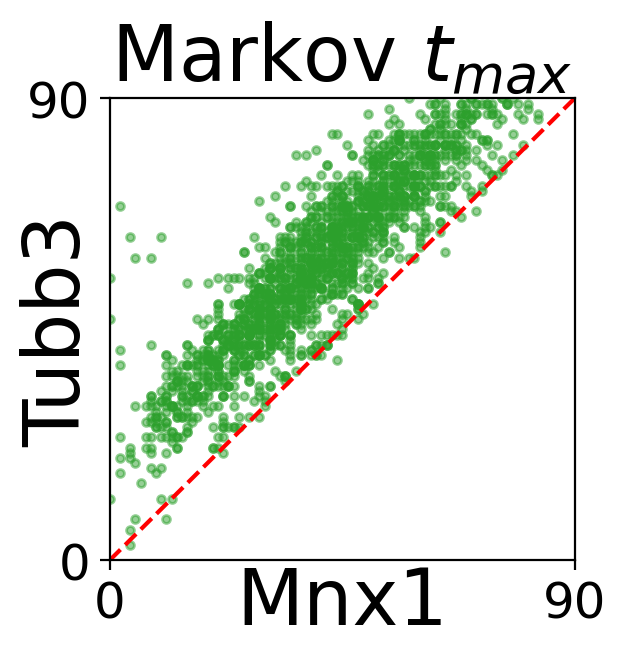

In [22]:
o = ['Mnx1','Tubb3']

fontsize=28

first = realign(get_gene(gex, o[0]))
second = realign(get_gene(gex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, zorder=1, color='tab:green')
plt.xlim(0,90)
plt.ylim(0,90)
plt.plot([0,90],[0,90], color='r', linestyle='--', zorder=2)
plt.xticks([0,90], fontsize=18)
plt.yticks([0,90], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"Markov $t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_mark3.png', bbox_inches='tight')

plt.show()

# Pseudotime

In [23]:
trajectories = pt10['MN']
gex = model.get_trajectory_gene_expression(trajectories)

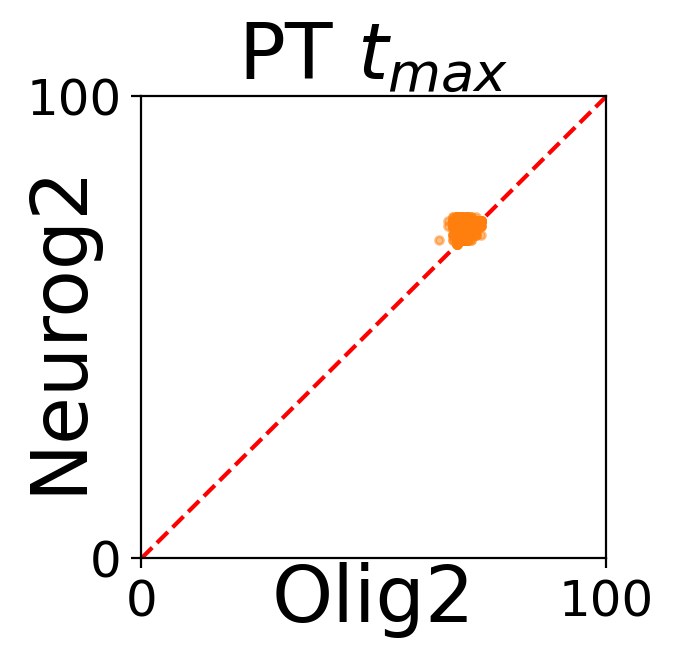

In [24]:
o = ['Olig2','Neurog2']

fontsize=28

first = realign(get_gene(gex, o[0]))
second = realign(get_gene(gex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, zorder=2, color='tab:orange')
plt.xlim(0,100)
plt.ylim(0,100)
plt.plot([0,100],[0,100], color='r', linestyle='--', zorder=1)
plt.xticks([0,100], fontsize=18)
plt.yticks([0,100], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"PT $t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_pt1.png', bbox_inches='tight')

plt.show()


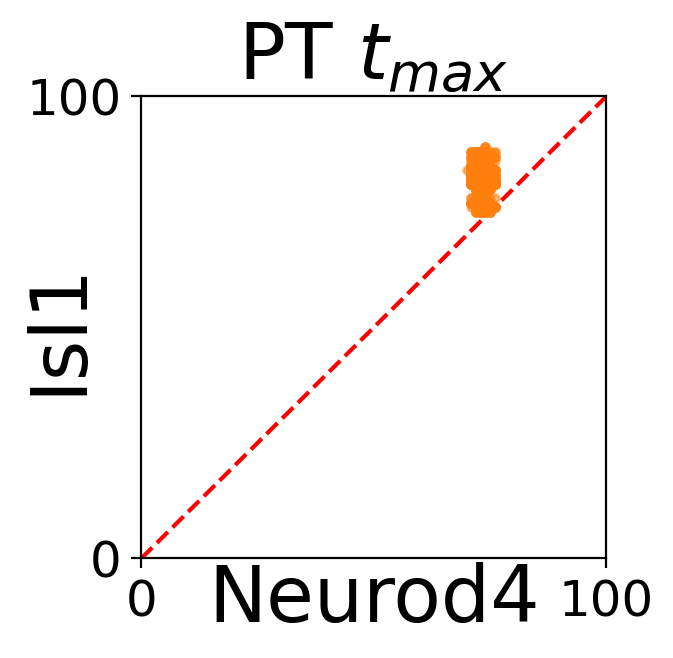

In [25]:
o = ['Neurod4','Isl1']

fontsize=28

first = realign(get_gene(gex, o[0]))
second = realign(get_gene(gex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, zorder=2, color='tab:orange')
plt.xlim(0,100)
plt.ylim(0,100)
plt.plot([0,100],[0,100], color='r', linestyle='--', zorder=1)
plt.xticks([0,100], fontsize=18)
plt.yticks([0,100], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"PT $t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_pt2.png', bbox_inches='tight')

plt.show()


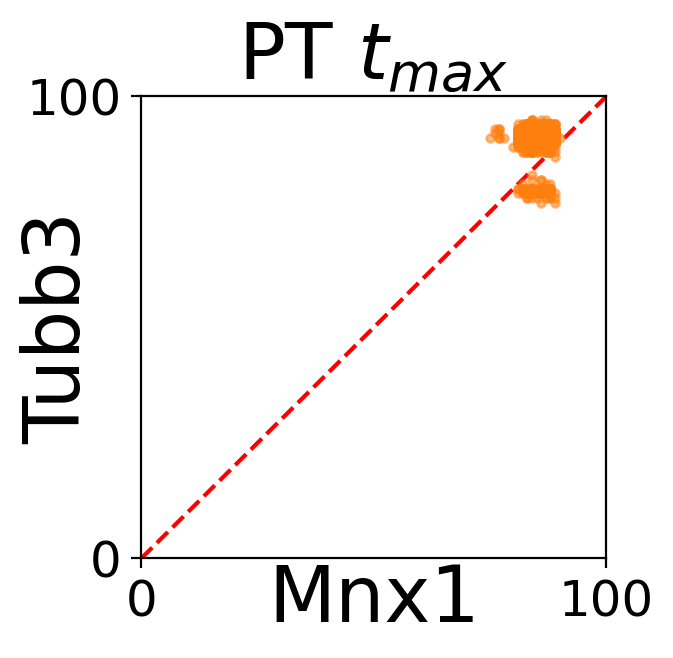

In [26]:
o = ['Mnx1','Tubb3']

fontsize=28

first = realign(get_gene(gex, o[0]))
second = realign(get_gene(gex, o[1]))

plt.figure(figsize=(3,3), dpi=200)
plt.scatter(argmax(first), argmax(second), s=8, alpha=0.5, zorder=2, color='tab:orange')
plt.xlim(0,100)
plt.ylim(0,100)
plt.plot([0,100],[0,100], color='r', linestyle='--', zorder=1)
plt.xticks([0,100], fontsize=18)
plt.yticks([0,100], fontsize=18)
plt.xlabel(f"{o[0]}", fontsize=fontsize, labelpad=-23)
plt.ylabel(f"{o[1]}", fontsize=fontsize, labelpad=-25)
plt.title(r"PT $t_{max}$", fontsize=fontsize)
plt.savefig('../figures/3.3_tmax_pt3.png', bbox_inches='tight')

plt.show()
